**Análisis de Series de Tiempo**

In [2]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Paso 1:**

*   Los archivos de datos contienen las observaciones promedio diarias. Al principio de cada archivo indica cuantas líneas contiene el encabezado, para considerarlo a la hora de leer el archivo CSV (aquí separado por espacios).
*   Nos interesa la columna de 'value' que corresponde a las concentraciones de CO2. Cuando hay datos faltantes, aparece el número -999.99. Habrá que reemplazarlo por NaN. Las series de tiempo son de mediados de 1970 al 2019-12-31. 
*   Para construir una serie de tiempo que deseamos analizar, se pide construir una columna de 'Fecha' variable de tipo datetime,  combinando las columnas 'year', 'month', y 'day'.
*   Después se pide construir un dataframe que contiene desde el inicio de 1980 hasta fin de 2019.
*   Convierte el dataframe anterior a serie de tiempo 'ts_test', usando 'Fecha' como índice.
*   La serie de tiempo de concentraciones de CO2, sólo deberá tener la Fecha como índice y la columna de CO2.
*   Puedes usar la función de Pandas ts_test.ffill(axis = 0, inplace=True), para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.

In [3]:

#Tomamos la dirección del archivo.
url = 'https://raw.githubusercontent.com/RaulACortez/FisicaComputacional1/main/FisicaComputacional1/Evaluaci%C3%B3n1/Hawaii.txt'

#Definimos nombres para las columnas.
my_cols = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=0, engine='python')

#Creamos una copia y conservamos el original.
df_work0 = df_dist.copy()

#reemplazamos los textos "Nulo" por espacio en blanco.
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='NaN', regex=True)

#Convertimos los valores de las variables ambientales a numeros flotantes.
cols_list = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

#Volveremos a hacer una copia.
df_work2 = df_work1.copy()

df_work2['Fecha'] = pd.to_datetime(df_work2[['year','month','day']]
                   .astype(str).apply(' '.join, 1), format='%Y %m %d')

df_work2['Fecha'] = (pd.to_datetime(df_work2['year'].astype(str) + '-' +
                                  df_work2['month'].astype(str) + '-' +
                                  df_work2['day'].astype(str)))


In [4]:
df_datos = df_work2.copy()
df_datos.info()
print(df_datos.head())
print(df_datos.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17166 entries, 0 to 17165
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   site_code             0 non-null      float64       
 1   year                  17166 non-null  int64         
 2   month                 17166 non-null  int64         
 3   day                   17166 non-null  int64         
 4   hour                  17166 non-null  int64         
 5   minute                17166 non-null  int64         
 6   second                17166 non-null  int64         
 7   time_decimal          17166 non-null  float64       
 8   Concentracion de CO2  13936 non-null  float64       
 9   value_std_dev         17166 non-null  float64       
 10  nvalue                17166 non-null  int64         
 11  latitude              17166 non-null  float64       
 12  longitude             17166 non-null  float64       
 13  altitude        

In [5]:
df_datos = df_datos.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_datos = df_datos.set_index('Fecha')
# Vamos a utilizar los últimos de datos, que corresponden al periodo 1980-2019
df_80 = df_datos[(df_datos['year'] >= 1980) & (df_datos['year'] < 2020)]
df_80.head()

,site_code,year,month,day,hour,minute,second,time_decimal,Concentracion de CO2,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,337.85,0.12,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,337.32,0.35,11,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,337.75,0.05,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,337.70,0.04,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,337.65,0.08,15,19.536,-155.576,3437.0,3397.0,40.0,NaN


In [6]:
df_80co2 = df_80.drop(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'], axis=1)
df_80co2.head(10)

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65
1980-01-06,337.25
1980-01-07,337.86
1980-01-08,337.31
1980-01-09,NaN


In [7]:
df_80co2.ffill(axis = 0, inplace=True)

**Paso 2:**

*   Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)
*   Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.
*   Si no es una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función.
*   Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto). 
*   Prueba la estacionaridad de la serie residuo.
*   Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.
*   Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.
*   Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.
*   Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.
*   Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez) 
*   Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q).
*   Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.
*   Calcula el error RMSE.
*   Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

In [8]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
start, end = '1980-01', '2019-12'

ts_80co2 = df_80co2.loc[start:end].copy()
ts_80co2.head()

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65


In [10]:
ts_80co2['Concentracion de CO2'].head()

Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
Name: Concentracion de CO2, dtype: float64

In [11]:
ts_test = ts_80co2['Concentracion de CO2'].copy()

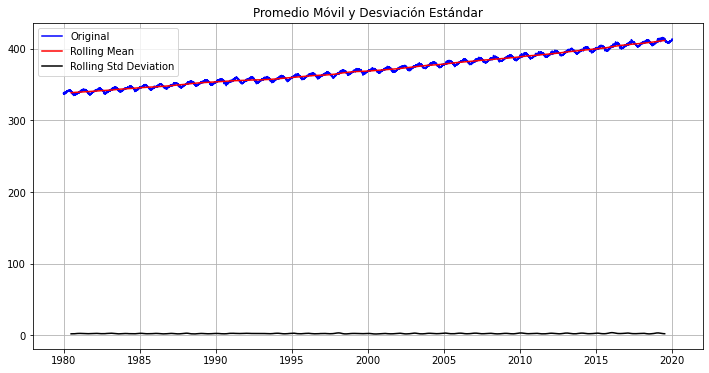

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.014427
p-value                            0.747966
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [12]:
#Realizamos la prueba de estacionaridad 
test_stationarity(ts_test)

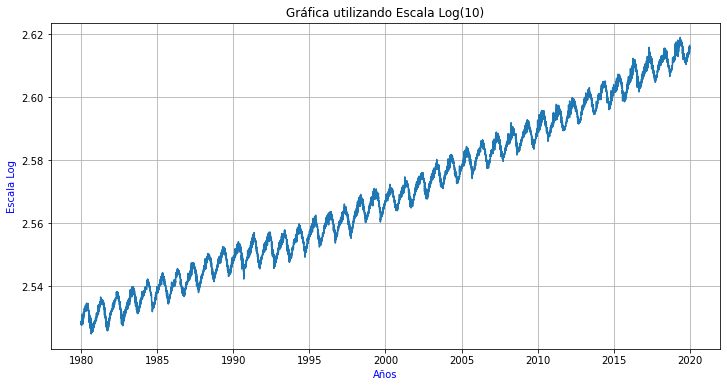

In [13]:
#Calculamos el promedio móvil
ts_test_log=np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años', color='b')
plt.ylabel('Escala Log', color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

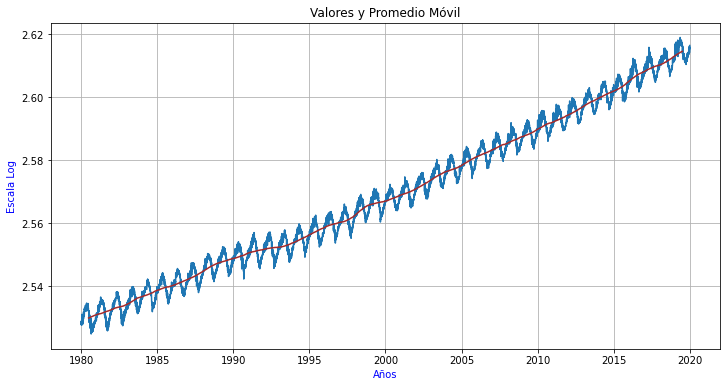

In [14]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [15]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion de CO2, dtype: float64

In [16]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.002344
1980-07-02    0.002353
1980-07-03    0.002196
1980-07-04    0.002207
1980-07-05    0.002192
Name: Concentracion de CO2, dtype: float64

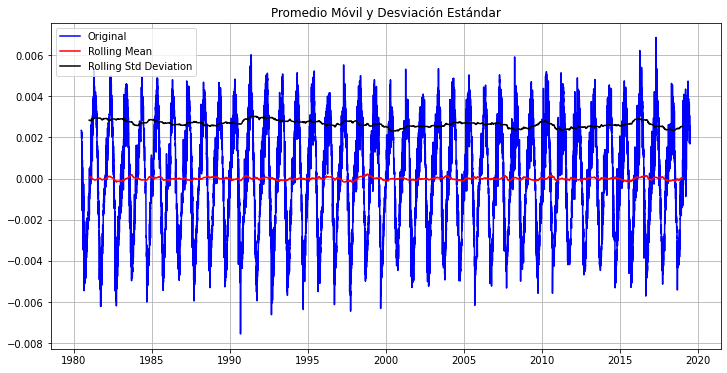

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400423e+01
p-value                        3.813700e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [17]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

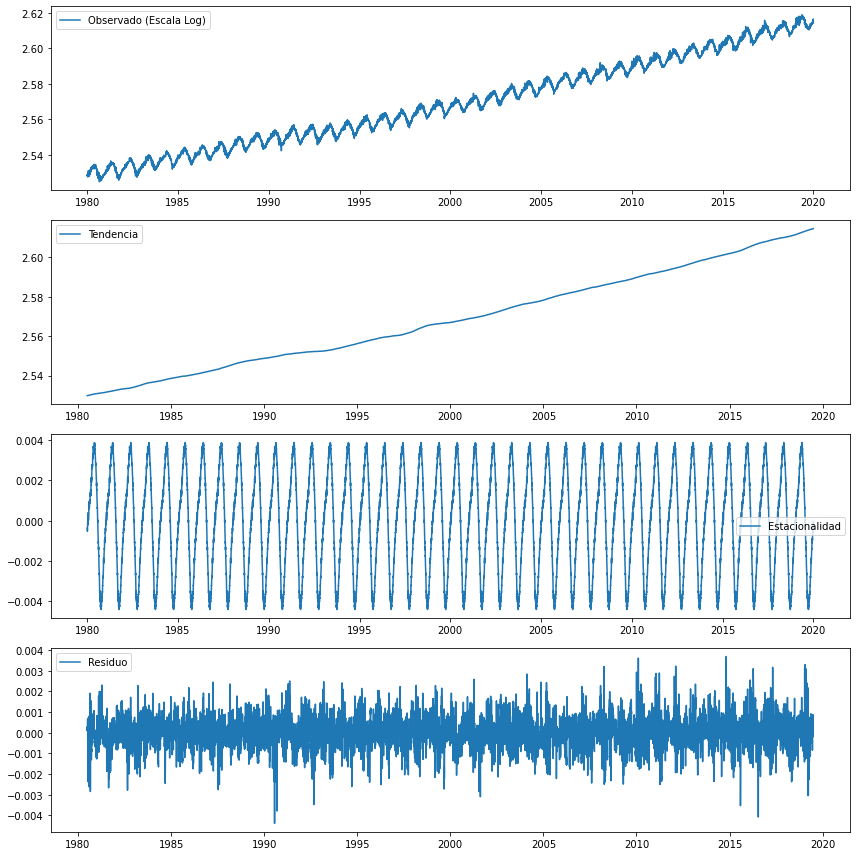

In [18]:
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

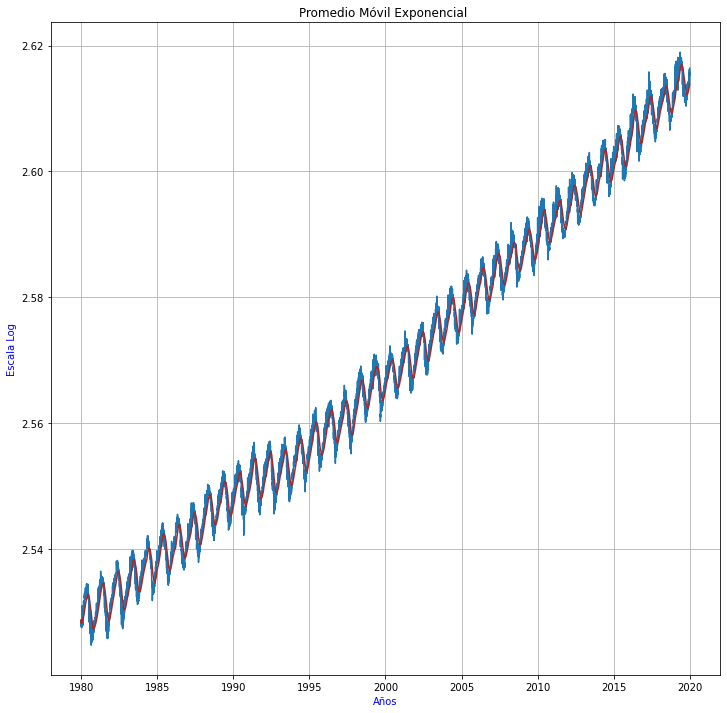

In [19]:
# Repetimos el cálculo usando promedios móviles exponenciales, 

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [20]:
EWM_avg.head()

Fecha
1980-01-01    2.528724
1980-01-02    2.528379
1980-01-03    2.528453
1980-01-04    2.528473
1980-01-05    2.528472
Name: Concentracion de CO2, dtype: float64

In [21]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

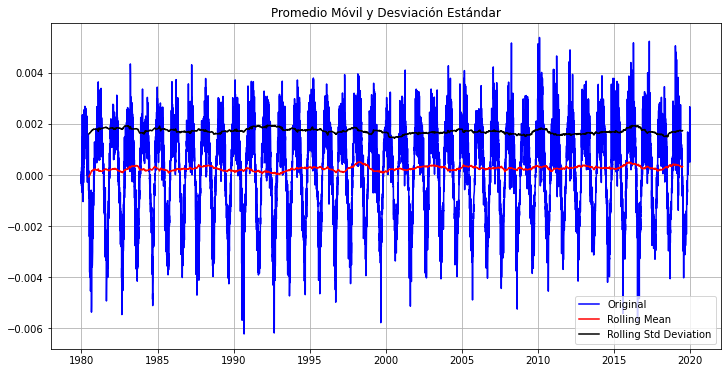

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.193061e+01
p-value                        4.791202e-22
#Lags Used                     4.200000e+01
Number of Observations Used    1.456700e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861738e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [22]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

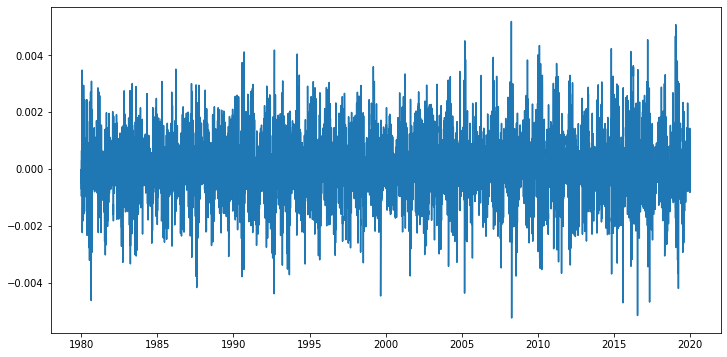

In [23]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

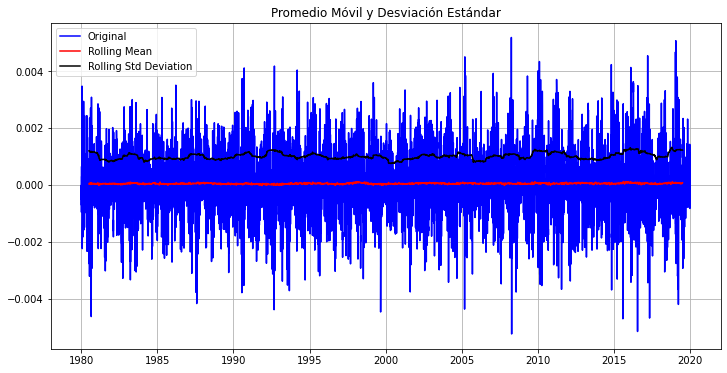

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.002234e+01
p-value                        1.666271e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [24]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [25]:
# Número de datos utilizados
len(ts_test_log_diff)

14603

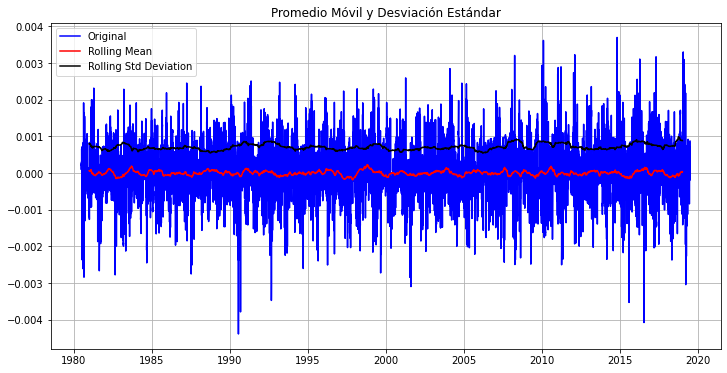

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.156045
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    14224.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [26]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

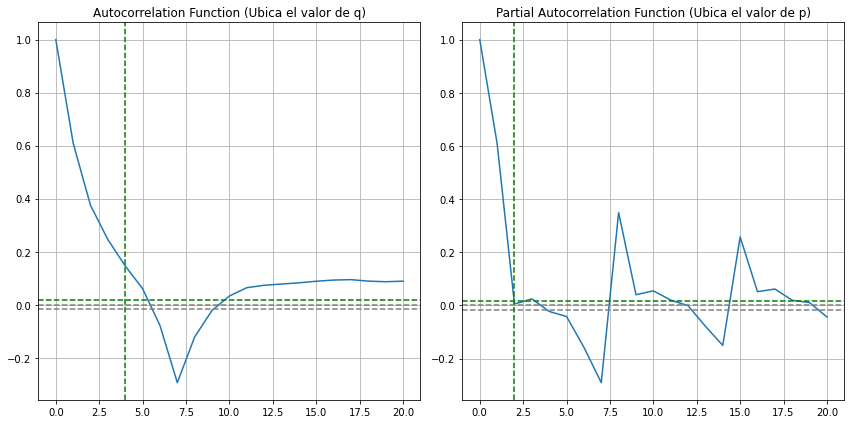

In [27]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Concentracion de CO2   No. Observations:                14609
Model:                     ARIMA(2, 1, 0)   Log Likelihood               87409.900
Method:                           css-mle   S.D. of innovations              0.001
Date:                    Thu, 25 Feb 2021   AIC                        -174811.800
Time:                            04:12:06   BIC                        -174781.442
Sample:                        01-02-1980   HQIC                       -174801.715
                             - 12-31-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         6.005e-06   3.53e-06      1.703      0.089   -9.05e-07    1.29e-05
ar.L1.D.Concentracion de CO2    -0.2437      

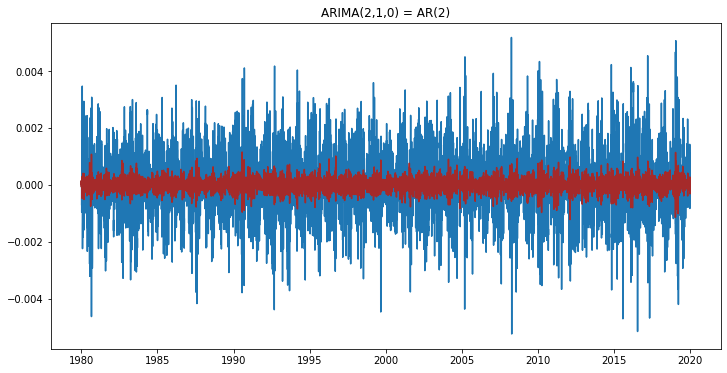

In [28]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Concentracion de CO2   No. Observations:                14609
Model:                     ARIMA(0, 1, 4)   Log Likelihood               87738.281
Method:                           css-mle   S.D. of innovations              0.001
Date:                    Thu, 25 Feb 2021   AIC                        -175464.561
Time:                            04:12:31   BIC                        -175419.025
Sample:                        01-02-1980   HQIC                       -175449.433
                             - 12-31-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.986e-06   2.05e-06      2.915      0.004    1.96e-06       1e-05
ma.L1.D.Concentracion de CO2    -0.3028      

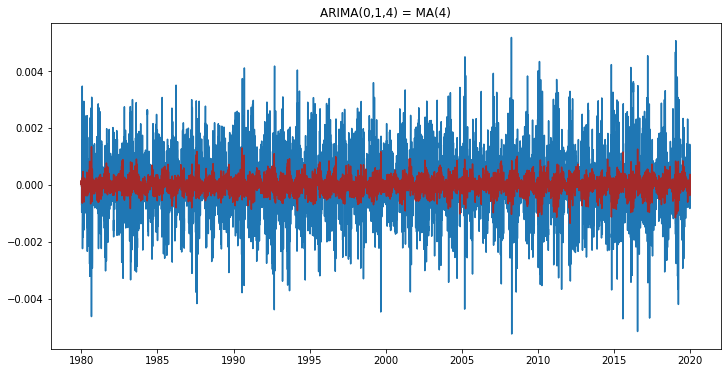

In [29]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                               ARIMA Model Results                                
Dep. Variable:     D.Concentracion de CO2   No. Observations:                14609
Model:                     ARIMA(2, 1, 4)   Log Likelihood               87722.093
Method:                           css-mle   S.D. of innovations              0.001
Date:                    Thu, 25 Feb 2021   AIC                        -175428.187
Time:                            04:13:03   BIC                        -175367.471
Sample:                        01-02-1980   HQIC                       -175408.016
                             - 12-31-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.985e-06   2.01e-06      2.973      0.003    2.04e-06    9.93e-06
ar.L1.D.Concentracion de CO2     0.3636      

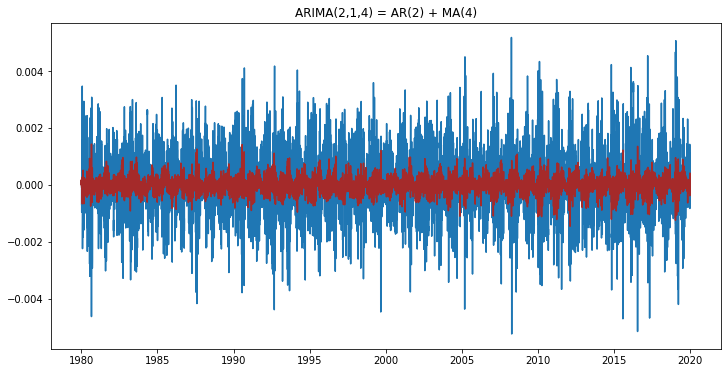

In [30]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [31]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03    0.000163
1980-01-04   -0.000015
1980-01-05    0.000003
1980-01-06    0.000013
                ...   
2019-12-27   -0.000125
2019-12-28   -0.000199
2019-12-29   -0.000009
2019-12-30   -0.000184
2019-12-31   -0.000262
Length: 14609, dtype: float64


In [32]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.528048
1980-01-03    2.528758
1980-01-04    2.528516
1980-01-05    2.528470
dtype: float64
Fecha
2019-12-27    2.615667
2019-12-28    2.615057
2019-12-29    2.615920
2019-12-30    2.616082
2019-12-31    2.616140
dtype: float64


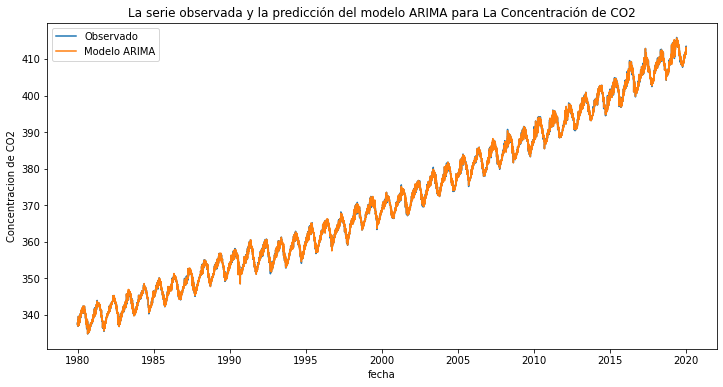

In [33]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('fecha')
plt.ylabel('Concentracion de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para La Concentración de CO2')
plt.legend(loc='best');

In [34]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.19281524384591034


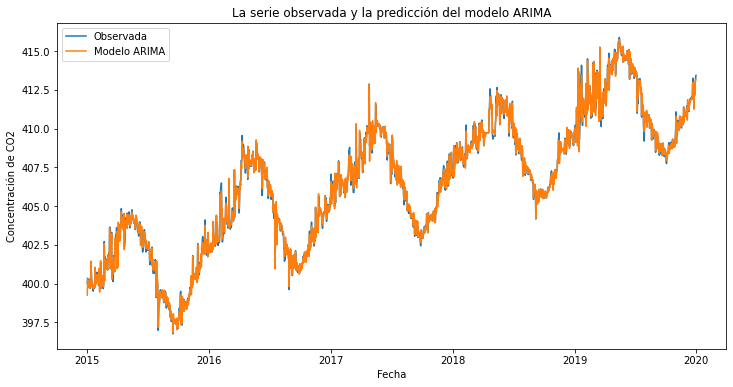

In [35]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');